# CSC 3105 Project

In [1]:
import os

DATASET_DIR = './UWB-LOS-NLOS-Data-Set/dataset'

# Load and Clean the Data

This code block performs the following operations:

1. Imports necessary libraries for data handling and cleaning.
2. Defines a function `load_data` to load the data from a given directory into a pandas dataframe.
3. Defines a function `clean_data` to clean the loaded data. The cleaning process includes:
   - Handling missing values by dropping them.
   - Removing duplicate rows.
   - Converting the 'NLOS' column to integer data type.
   - Normalizing the 'Measured range (time of flight)' column.
   - Creating new features 'FP_SUM' and 'SNR'.
   - One-hot encoding categorical features.
   - Performing feature extraction on 'CIR' columns.
   - Dropping the original 'CIR' columns.
   - Checking for columns with only one unique value and dropping them.
4. Checks if a pickle file with the cleaned data exists. If it does, it loads the data from the file. If it doesn't, it loads and cleans the data using the defined functions.
5. Prints the first few rows of the cleaned data and its column headers.

In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import pickle

def load_data(dataset_dir):
    # Load the data
    file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames]
    data = pd.concat((pd.read_csv(file_path) for file_path in file_paths))
    print(f"Original data shape: {data.shape}")
    return data

def clean_data(data):
    # Calculate total number of missing values in the data
    # This is important to understand the quality of the data
    total_missing = data.isnull().sum().sum()
    print(f"Total number of missing values: {total_missing}")

    # Data has no missing values
    data = data.dropna()

    # Data has no duplicate rows
    data = data.drop_duplicates()

    # Convert 'NLOS' column to integer data type (0 for LOS, 1 for NLOS)
    # This is necessary for further analysis as some algorithms can only handle numeric data
    data['NLOS'] = data['NLOS'].astype(int)

    # Normalize 'Measured range (time of flight)' column using MinMaxScaler
    # Normalization ensures that all features have the same scale
    scaler = MinMaxScaler()
    data['RANGE'] = scaler.fit_transform(data[['RANGE']])

    # Create new feature 'FP_SUM' by adding 'FP_AMP1', 'FP_AMP2', and 'FP_AMP3'
    # This can potentially enhance the model's performance by introducing new meaningful information
    data['FP_SUM'] = data['FP_AMP1'] + data['FP_AMP2'] + data['FP_AMP3']

    # Create new feature 'SNR' by dividing 'CIR_PWR' by 'STDEV_NOISE'
    # This can potentially enhance the model's performance by introducing new meaningful information
    data['SNR'] = data['CIR_PWR'] / data['STDEV_NOISE']

    # One-hot encode categorical features
    # This is necessary as many machine learning algorithms cannot handle categorical data directly
    categorical_features = ['CH', 'FRAME_LEN', 'PREAM_LEN', 'BITRATE', 'PRFR']
    encoder = LabelEncoder()
    for feature in categorical_features:
        data[feature] = encoder.fit_transform(data[feature])

    # List of CIR columns
    cir_columns = [f"CIR{i}" for i in range(1016)]

    # Feature extraction on 'CIR' columns
    # This can potentially enhance the model's performance by introducing new meaningful information
    data['CIR_MEAN'] = data[cir_columns].mean(axis=1)
    data['CIR_STD'] = data[cir_columns].std(axis=1)
    data['CIR_SKEW'] = data[cir_columns].apply(stats.skew, axis=1)
    data['CIR_KURT'] = data[cir_columns].apply(stats.kurtosis, axis=1)

    # Drop the original 'CIR' columns
    # This is done to reduce the dimensionality of the data after extracting the necessary information
    data = data.drop(columns=cir_columns)

    # List of columns to check for unique values
    columns_to_check = ['CH', 'PREAM_LEN', 'BITRATE', 'PRFR']

    # Iterate over the columns
    for column in columns_to_check:
        # If the column has only one unique value, drop it
        # Columns with only one unique value do not contribute to the model's performance
        if data[column].nunique() == 1:
            data = data.drop(column, axis=1)

    # Print the shape of the cleaned data
    print(f"Cleaned data shape: {data.shape}")
    
    # Return the cleaned data
    return data

# Check if the file exists
if os.path.exists('data.pkl'):
    # If the file exists, load it
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
else:
    # If the file doesn't exist, load and clean the data
    data = load_data(DATASET_DIR)
    data = clean_data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f)

print(data.head())

# Print Headers
print(data.columns)

   NLOS     RANGE  FP_IDX  FP_AMP1  FP_AMP2  FP_AMP3  STDEV_NOISE  CIR_PWR  \
0     1  0.220557   749.0   4889.0  13876.0  10464.0        240.0   9048.0   
1     1  0.162027   741.0   2474.0   2002.0   1593.0         68.0   6514.0   
2     1  0.156674   744.0   1934.0   2615.0   4114.0         52.0   2880.0   
3     1  0.045325   748.0  16031.0  17712.0  10420.0         64.0  12855.0   
4     0  0.041399   743.0  20070.0  19886.0  15727.0         76.0  11607.0   

   MAX_NOISE  RXPACC  FRAME_LEN  PREAM_LEN   FP_SUM         SNR    CIR_MEAN  \
0     3668.0  1024.0          2          0  29229.0   37.700000  768.607283   
1     1031.0  1024.0          2          0   6069.0   95.794118  416.879921   
2      796.0  1024.0          0          0   8663.0   55.384615  378.266732   
3     1529.0   323.0          2          0  44163.0  200.859375  333.926181   
4     2022.0   296.0          0          0  55683.0  152.723684  391.251969   

       CIR_STD   CIR_SKEW    CIR_KURT  
0  1122.978435  

The selected code is performing data standardization, which is a common preprocessing step in many machine learning workflows. 

The purpose of standardization is to transform the data such that it has a mean of 0 and a standard deviation of 1. This is done to ensure that all features have the same scale, which is a requirement for many machine learning algorithms.

The mathematical formulas used in this process are as follows:

1. Calculate the mean (μ) of the data:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
Where:
- $n$ is the number of observations in the data
- $x_i$ is the value of the $i$-th observation
- $\sum$ denotes the summation over all observations

2. Standardize the data by subtracting the mean from each observation and dividing by the standard deviation:

$$
\text{Data}_i = \frac{x_i - \mu}{\sigma}
$$
Where:
- $\text{Data}_i$ is the standardized value of the $i$-th observation
- $\sigma$ is the standard deviation of the data
- $x_i$ is the value of the $i$-th observation
- $\mu$ is the mean of the data

The `StandardScaler` class from the `sklearn.preprocessing` module is used to perform this standardization. The `fit_transform` method is used to calculate the mean and standard deviation of the data and then perform the standardization.

**Note:** By setting the explained variance to 0.95, we are saying that we want to choose the smallest number of principal components such that 95% of the variance in the original data is retained. This means that the transformed data will retain 95% of the information of the original data, while potentially having fewer dimensions.


In [3]:
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

# Standardize the data
numerical_cols = data.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Initialize PCA with the desired explained variance
pca = PCA(0.95)

# Fit PCA to your data
pca.fit(data)

# Get the number of components
num_components = pca.n_components_

print(f"The number of principle components after PCA is {num_components}")

The number of principle components after PCA is 10


# Perform Dimensionality Reduction with PCA

We can use the `transform` method of the `PCA` object to project the original data onto the principal components. This will give us the transformed data with the desired number of components.

In [4]:
# Project original data to PC with the highest eigenvalue
data_pca = pca.transform(data)

# Create a dataframe with the principal components
data_pca_df = pd.DataFrame(data_pca, columns=[f"PC{i}" for i in range(1, num_components + 1)])

# Print the number of components in the original and PCA transformed data
print(f"Original number of components: {data.shape[1]}")
print(f"Number of components after PCA: {num_components}")

# Compare the number of components in the original and PCA transformed data
if data.shape[1] > num_components:
    print("PCA has successfully reduced the number of components.")
elif data.shape[1] < num_components:
    print("Unexpectedly, PCA has increased the number of components.")
else:
    print("The number of components remains unchanged after PCA.")

Original number of components: 18
Number of components after PCA: 10
PCA has successfully reduced the number of components.


## Data Mining / Machine Learning

### I. Supervised Learning
- **Decision**: Supervised learning is used due to the labeled dataset.
- **Algorithm**: Random Forest Classifier is preferred for its performance in classification tasks.

### II. Training/Test Split Ratio
- **Decision**: 70:30 split is chosen for training/test dataset.
- **Reasoning**: This split ensures sufficient data for training and testing.

### III. Performance Metrics
- **Classification Accuracy**: Measures the proportion of correctly classified instances.
- **Confusion Matrix**: Provides a summary of predicted and actual classes.
- **Classification Report**: Provides detailed metrics such as precision, recall, F1-score, and support for each class.

The Random Forest Classifier is trained on the training set and evaluated on the test set using accuracy and classification report metrics.


# Split the data into training and testing sets

The next step is to split the data into training and testing sets. This is a common practice in machine learning, where the training set is used to train the model, and the testing set is used to evaluate its performance.

We will use the `train_test_split` function from the `sklearn.model_selection` module to split the data into training and testing sets. We will use 70% of the data for training and 30% for testing, which is a common split ratio.

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(data_pca_df, data['NLOS'], test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data_pca_df, data['NLOS'], test_size=0.3, random_state=42)


# Train a Random Forest Classifier

The next step is to train a machine learning model on the training data. We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to train a random forest classifier.

The random forest classifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

We will use the `fit` method of the `RandomForestClassifier` object to train the model on the training data.

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Evaluate the Model

To evaluate the performance of the trained model on the testing data, we will use the `predict` method of the `RandomForestClassifier` object to make predictions on the testing data. We will then use the `accuracy_score` and `classification_report` functions from the `sklearn.metrics` module to calculate the accuracy and generate a classification report.

- **Accuracy:** The accuracy score function calculates the proportion of correctly classified instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as:

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. It is calculated as:

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

- **F1 Score:** The weighted average of precision and recall. It is calculated as:

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Support:** The number of actual occurrences of the class in the dataset.

The classification report provides a summary of the precision, recall, F1-score, and support for each class in the testing data, giving insight into how well the model is performing for each class.


In [7]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.9985714285714286
Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      6311
         1.0       1.00      1.00      1.00      6289

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600


# Visualize a Decision Tree from the Random Forest


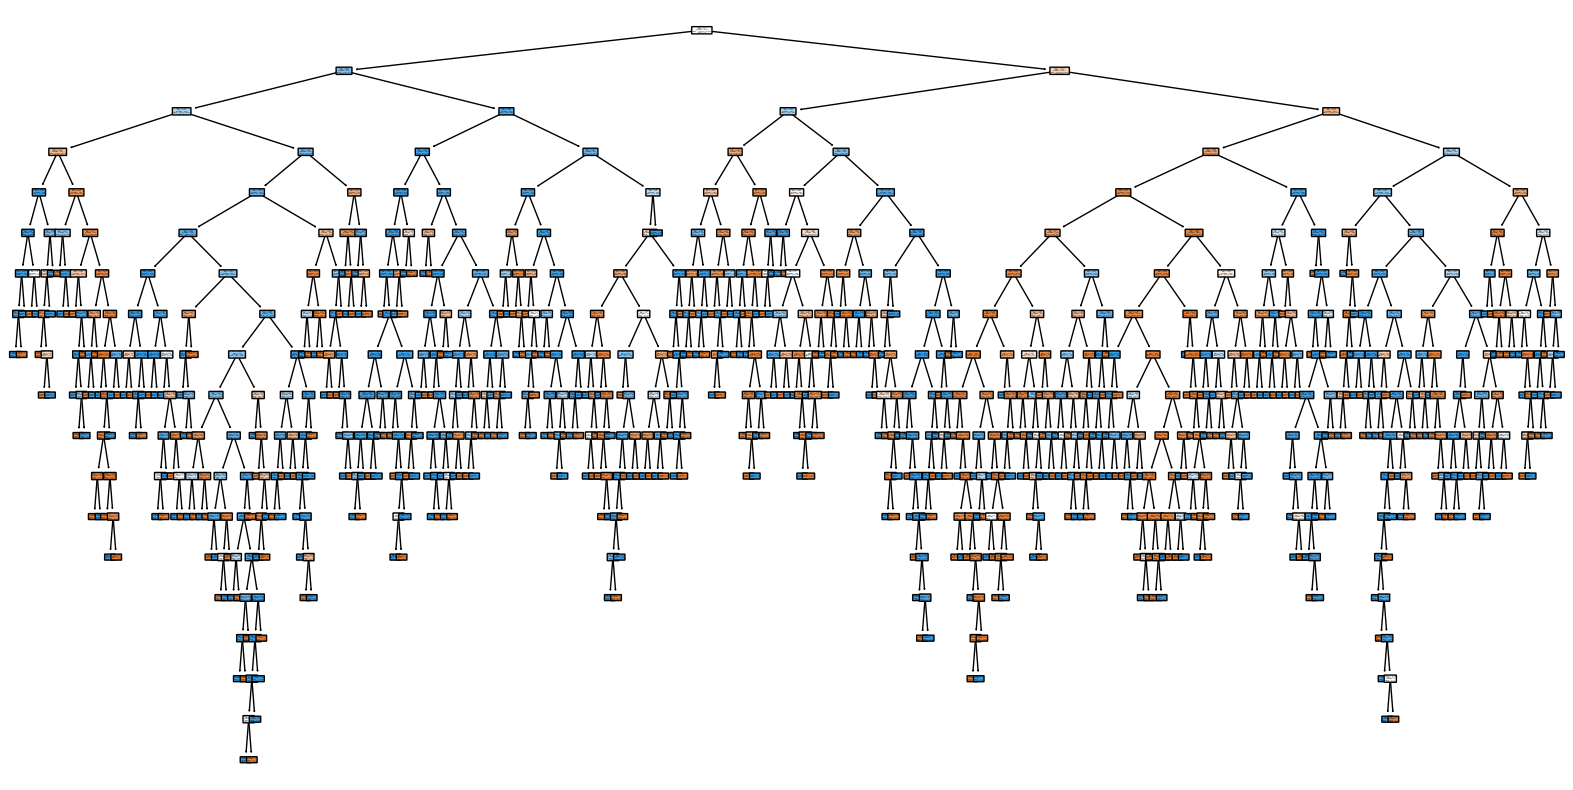

In [8]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
estimator = classifier.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          filled=True,
          rounded=True,
          class_names=['NLOS', 'LOS'],
          feature_names=data_pca_df.columns)
plt.show()

# Support Vector Machine (SVM)

In [9]:
from sklearn.svm import SVC

# Support Vector Machine
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [10]:
from sklearn.metrics import accuracy_score

# Predict the labels for the test set with each model
y_pred_svm = svm.predict(X_test)

# Calculate the accuracy of each model
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print the accuracy of each model
print(f"Accuracy of SVM: {accuracy_svm}")

Accuracy of SVM: 0.9997619047619047


# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [12]:
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy of Logistic Regression: {accuracy_log_reg}")

Accuracy of Logistic Regression: 0.9996031746031746


# Gradient Boosting Classifier

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)


GradientBoostingClassifier(random_state=42)

In [14]:
y_pred_gbc = gbc.predict(X_test)
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
print(f"Accuracy of Gradient Boosting Classifier: {accuracy_gbc}")


Accuracy of Gradient Boosting Classifier: 0.9983333333333333


# K-Nearest Neighbors (KNN, K=3)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [16]:
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy of K-Nearest Neighbors: {accuracy_knn}")

Accuracy of K-Nearest Neighbors: 0.998968253968254


# Same Operations on the Original Data (no PCA)

In [17]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data['NLOS'], test_size=0.3, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      6311
         1.0       1.00      1.00      1.00      6289

    accuracy                           1.00     12600
   macro avg       1.00      1.00      1.00     12600
weighted avg       1.00      1.00      1.00     12600


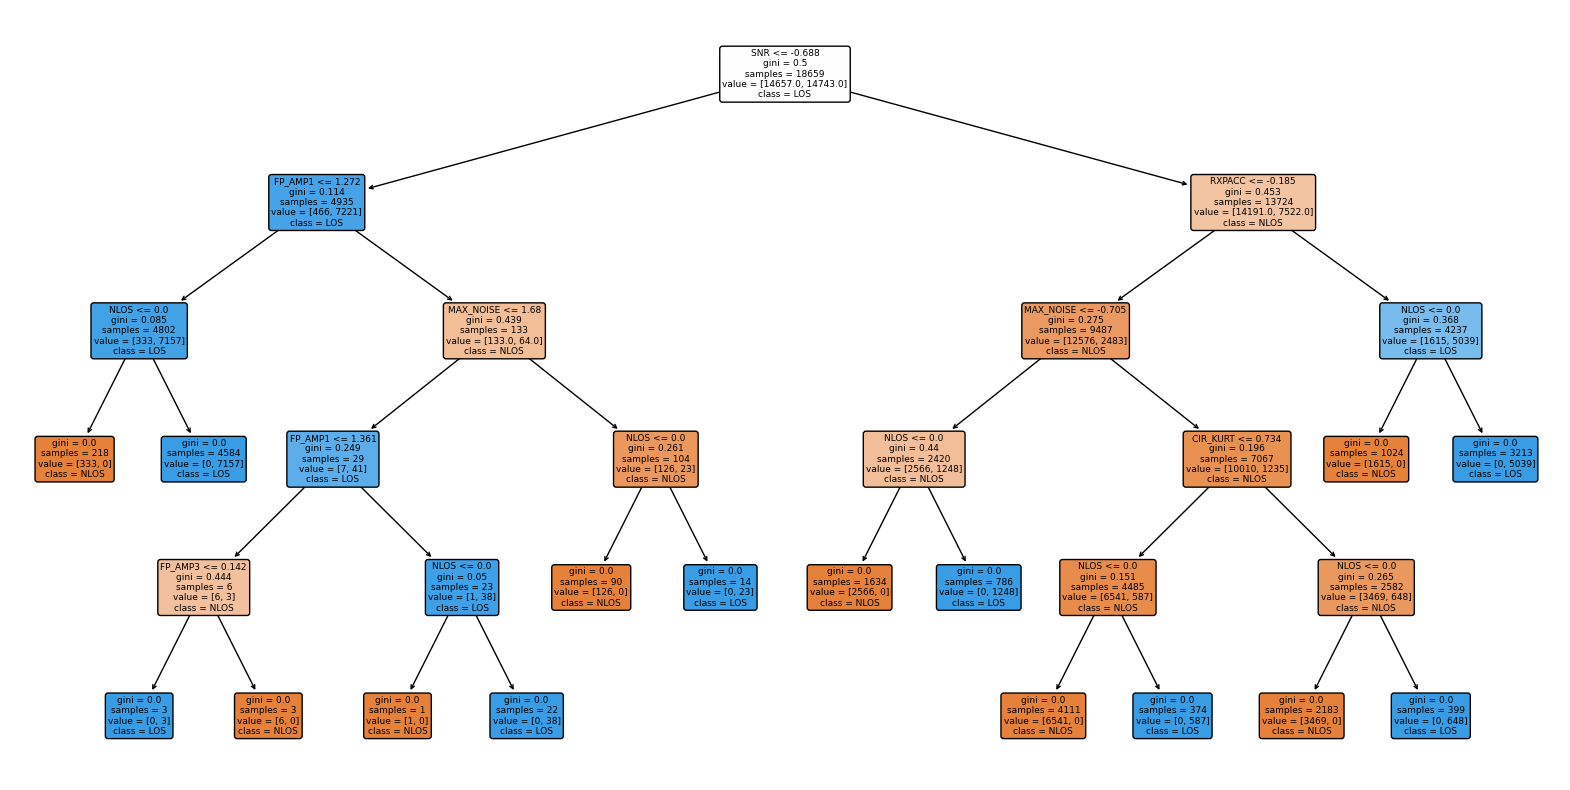

In [18]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
estimator = classifier.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator,
          filled=True,
          rounded=True,
          class_names=['NLOS', 'LOS'],
          feature_names=data.columns)
plt.show()

# Support Vector Machine (SVM) with Original Data

In [19]:
# Support Vector Machine
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict the labels for the test set with each model
y_pred_svm = svm.predict(X_test)

# Calculate the accuracy of each model
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print the accuracy of each model
print(f"Accuracy of SVM: {accuracy_svm}")

Accuracy of SVM: 1.0


# Logistic Regression with Original Data

In [20]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

print(f"Accuracy of Logistic Regression: {accuracy_log_reg}")

Accuracy of Logistic Regression: 1.0


# Gradient Boosting Classifier with Original Data

In [21]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
print(f"Accuracy of Gradient Boosting Classifier: {accuracy_gbc}")


Accuracy of Gradient Boosting Classifier: 1.0


# K-Nearest Neighbors (KNN, K=3) with Original Data

In [22]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy of K-Nearest Neighbors: {accuracy_knn}")

Accuracy of K-Nearest Neighbors: 1.0


In [23]:
# Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

# Define the model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=128)

# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

2024-02-27 15:55:04.018321: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 15:55:04.022536: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 15:55:04.069157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 15:55:04.069201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 15:55:04.070363: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/100
230/230 [==============================] - 1s 1ms/step - loss: -19.1327 - accuracy: 0.3398
Epoch 2/100
230/230 [==============================] - 0s 1ms/step - loss: -409.4561 - accuracy: 0.3653
Epoch 3/100
230/230 [==============================] - 0s 1ms/step - loss: -1941.1949 - accuracy: 0.3702
Epoch 4/100
230/230 [==============================] - 0s 1ms/step - loss: -5258.8105 - accuracy: 0.3714
Epoch 5/100
230/230 [==============================] - 0s 1ms/step - loss: -10845.6953 - accuracy: 0.3721
Epoch 6/100
230/230 [==============================] - 0s 1ms/step - loss: -19072.3613 - accuracy: 0.3722
Epoch 7/100
230/230 [==============================] - 0s 1ms/step - loss: -30220.3184 - accuracy: 0.3723
Epoch 8/100
230/230 [==============================] - 0s 1ms/step - loss: -44540.8750 - accuracy: 0.3719
Epoch 9/100
230/230 [==============================] - 0s 1ms/step - loss: -62233.3164 - accuracy: 0.3722
Epoch 10/100
230/230 [==============================]